## 1. 导入基础库

In [ ]:
import warnings
warnings.filterwarnings('ignore') # 忽略warning错误信息

import gym

from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2

## 2. 全流程过程

In [5]:
# 定义环境
env = gym.make('CartPole-v1')
# Optional: PPO2 requires a vectorized environment to run
# the env is now wrapped automatically when passing it to the constructor
# env = DummyVecEnv([lambda: env])

# 定义agent
model = PPO2(MlpPolicy, env, verbose=0)
# 训练agent
model.learn(total_timesteps=10000)

# 重置初始观测值
obs = env.reset()
print(obs)
for i in range(100):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
env.close()


[ 0.00880259 -0.04041666  0.00259371  0.01210965]


## 3. 可以将模型的定义与训练整合为一条代码

In [18]:
# just train a model with a one liner if the environment is registered in Gym and if the policy is registered:
from stable_baselines import PPO2

# 将模型的定义与训练合并在一起
model = PPO2('MlpPolicy', 'CartPole-v1').learn(10000)

# 重置初始观测值
obs = env.reset()
print(obs)
for i in range(100):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
env.close()

[-0.04692927 -0.00025166 -0.00561632  0.01106807]


## 4. 评估模型

### 4.1 自定义评估函数

In [13]:
# 评估模型
import numpy as np
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
%matplotlib inline

def evaluate(model, num_episodes=100):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = model.get_env()
    all_episode_rewards = []
    
    for i in range(num_episodes):
        episode_rewards = []
        done = False
        obs = env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)
        
        all_episode_rewards.append(sum(episode_rewards))
        # 通过画图直观的显示reward的变化
        plt.plot(all_episode_rewards) 

    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward


Mean reward: 153.77 Num episodes: 100


153.77

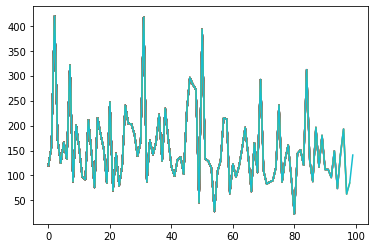

In [23]:
from stable_baselines import A2C
model = PPO2('MlpPolicy', 'CartPole-v1').learn(10000)

evaluate(model)

### 4.2 调研标准评估函数

In [24]:
# 调用标准评估函数
from stable_baselines.common.evaluation import evaluate_policy

model = A2C('MlpPolicy', 'CartPole-v1').learn(10000)

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:237.77 +/- 43.00


In [26]:
# 训练和评估模型
# 训练前
model = PPO2(MlpPolicy, env, verbose=0)

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

#训练后
model.learn(total_timesteps=10000)
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")


mean_reward:47.90 +/- 19.70
mean_reward:313.09 +/- 123.17


## 5 DQN模型的使用

### 5.1 Vanilla DQN: DQN without extensions

In [39]:
# Same as before we instantiate the agent along with the environment
from stable_baselines import DQN

# 模型的定义
# Deactivate all the DQN extensions to have the original version
# In practice, it is recommend to have them activated
kwargs = {'double_q': False, 'prioritized_replay': False, 'policy_kwargs': dict(dueling=False)}
# Note that the MlpPolicy of DQN is different from the one of PPO
# but stable-baselines handles that automatically if you pass a string
dqn_model = DQN('MlpPolicy', 'CartPole-v1', verbose=0, **kwargs)

# 评估模型
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:401.15 +/- 123.40


In [40]:
# 训练模型
# Train the agent for 10000 steps
dqn_model.learn(total_timesteps=10000, log_interval=10)

#训练后
mean_reward, std_reward = evaluate_policy(dqn_model, env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:173.31 +/- 20.03


Mean reward: 173.58 Num episodes: 100


173.58

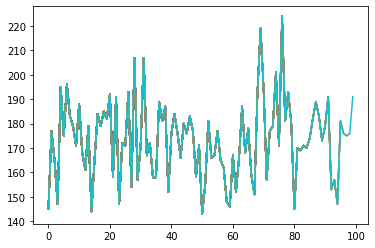

In [41]:
evaluate(dqn_model)

### 5.2 DQN + Prioritized Replay

In [32]:
# Activate only the prioritized replay
kwargs = {'double_q': False, 'prioritized_replay': True, 'policy_kwargs': dict(dueling=False)}
dqn_per_model = DQN('MlpPolicy', 'CartPole-v1', verbose=0, **kwargs)

dqn_per_model.learn(total_timesteps=10000, log_interval=10)

#训练后
mean_reward, std_reward = evaluate_policy(dqn_per_model, env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:127.97 +/- 13.53


Mean reward: 357.66 Num episodes: 100


357.66

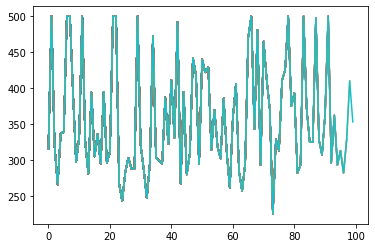

In [37]:
evaluate(dqn_per_model)

### 5.3 DQN + Prioritized Experience Replay + Double Q-Learning + Dueling

In [34]:
# Activate all extensions
kwargs = {'double_q': True, 'prioritized_replay': True, 'policy_kwargs': dict(dueling=True)}
dqn_full_model = DQN('MlpPolicy', 'CartPole-v1', verbose=0, **kwargs)

dqn_full_model.learn(total_timesteps=10000, log_interval=10)

#训练后
mean_reward, std_reward = evaluate_policy(dqn_full_model, env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:235.83 +/- 57.50


Mean reward: 227.14 Num episodes: 100


227.14

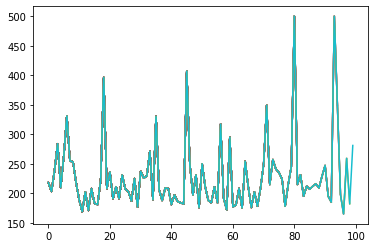

In [36]:
evaluate(dqn_full_model)